# LSTM v.s. Time Series Forecasting on Seattle Bicycle Usage

In this notebook, I would like to explore how Recurrent Neural Networks (RNN), i.e., Long-Short Term Memory (LSTM), performs compared with traditional time series modeling. The below models will be implemented:

1. LSTM

2. Moving average

3. Simple Exponential Smoothing

4. Holt-Winter Exponential Smoothing

5. SARIMA

6. SARIMAX

In [23]:
# import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
from pyramid.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import holidays
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(1337) # for reproducibility
plt.rcParams["figure.figsize"] = (20, 10)

## About Data

The data records the number of bikes that cross the Fremont bridge using the pedestrian/bicycle pathways since 2012.

Data Provided by: City of Seattle

Data source: https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

This post is inspired by Chapter 03.11 in Python Data Science Handbook: https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.11-Working-with-Time-Series.ipynb

As of Aug 2019, the CSV can be downloaded as follows:


In [3]:
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2015-02-24 02:00:00,3.0,3.0
2019-01-01 00:00:00,0.0,9.0
2019-01-01 01:00:00,2.0,22.0
2016-02-15 00:00:00,3.0,3.0
2019-01-01 02:00:00,1.0,11.0


## EDA

As it is shown above, the dataframe contains two columns: the traffic from bridge east and west sidewalk. 

For convenience, I'll further process this dataset by shortening the column names and adding a "Total" column.

In [4]:
data.columns = ['West', 'East']
data['Total'] = data.eval('West + East')
data.dropna().describe()

,West,East,Total
count,59823.000000,59823.000000,59823.000000
mean,52.619795,60.262324,112.882119
std,67.734326,87.871363,143.101423
min,0.000000,0.000000,0.000000
25%,6.500000,7.000000,15.000000
50%,29.000000,30.000000,61.000000
75%,70.000000,73.000000,147.000000
max,698.000000,850.000000,1097.000000


The ~25,000 hourly samples are far too dense for us to make much sense of. For simplicity, let's aggregate to weekly level.

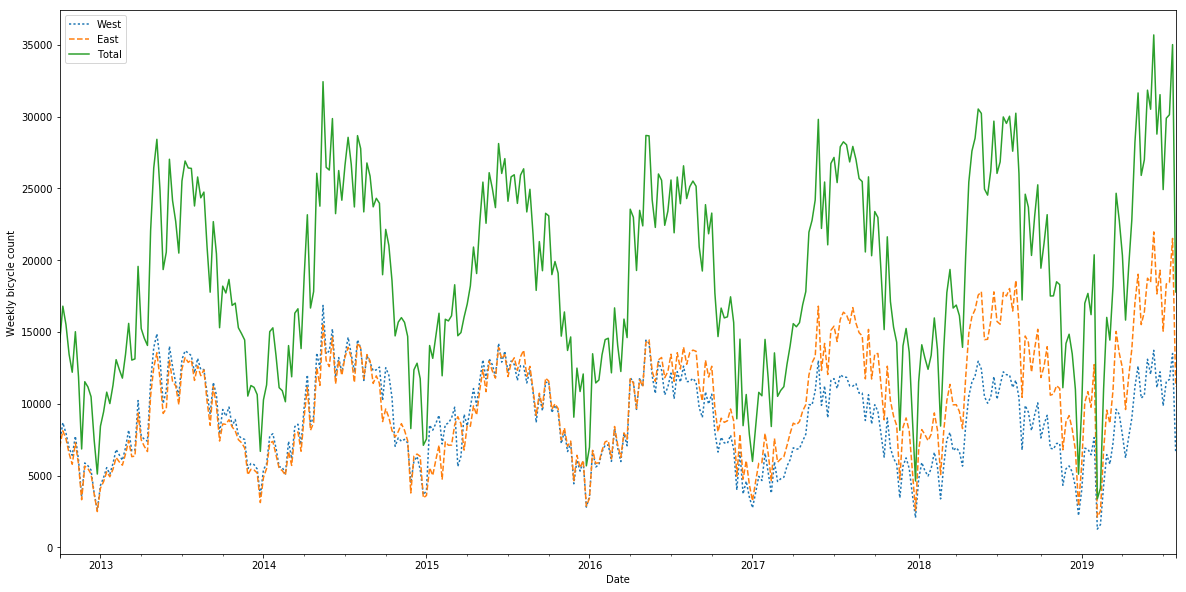

In [24]:
weekly = pd.DataFrame(data.resample('W').sum())
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')

weekly = weekly.loc[:, 'Total':]

A clear yearly seasonality can be observed from the above plot. The peak is reached in summer time when there is less rain (as you can imagine what happens in Seattle).

## LSTM

In this part, I would like to build a LSTM model to forecast bike count.

### Data prepocessing

Firstly, it's essential to split train and test set.

In [14]:
# split into train & test
size = int(len(weekly) * .8)
train, test = weekly[0:size], weekly[size:len(weekly)]

The following three data transforms are performed on the dataset prior to fitting a model and making a forecast.

1. Transform the time series data so that it is stationary. Specifically, a lag=1 differencing to remove the increasing trend in the data. This can be skipped since our data looks stable.


2. Transform the observations to have a specific scale. Specifically, to rescale the data to values between 0 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.


3. Transform the time series into a supervised learning problem. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time timestep.


#### Scaling
Then scaling is required in order to make values normalized. Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
The formula for feature scaling is shown below:


$$ Xscaled = (X - min(X))  /  (max(X) - min(X)) $$

In [15]:
# Convert training set to array
training_set = train.iloc[:, 0:1].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

#### Transformation

Here I use the first 60 weeks to predict the bicycle usage during 61th week, then walk ahead one step to forecast the 62th week and repeat the process.



In [16]:
# Create a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

A special data structure is required for RNN setup. We need to reshape dataset into three dimensions:

[batch_size (no. of observations), timesteps, input_dim]

In [ ]:
# Reshape to 3 dimensions: batch_size (no. of observations), timesteps, input_dim (no. of predictors)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Building the RNN

I will use a base stateful LSTM model with 50 neuron fit for 100 epochs. 

1. Batch size:

Batch size denotes the number of training samples in one forward/backward pass. This is the subset size of your training sample (e.g. 100 out of 1000) which is going to be used in order to train the network during its learning process. 
A batch size of 32 means that the model will be fit on every 32 observations and then re-adjust the weights (i.e., backpropagation). 

2. Epoch:

Epochs indicates how many iterations you want your model to be trained (i.e., being forepropagated inside neural network and then backpropagared to adjust weights).
Ideally, more training epochs would be used (such as 1000 or 1500), but this was truncated to 100 to keep run times reasonable.

3. Units:

The network has one input, three hidden layers with 50 units for each, and an output layer with 1 unit. The default tanh activation functions are used in the LSTM units and a linear activation function in the output layer.

4. Dropout:

Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This has the effect of reducing overfitting and improving model performance. In my case, 20% of neurons to be dropped out to avoid overfit.

The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.

In [33]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2)) 

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
225/225 [==============================] - 10s 43ms/step - loss: 0.2025
Epoch 2/100
225/225 [==============================] - 2s 11ms/step - loss: 0.0679
Epoch 3/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0576
Epoch 4/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0546
Epoch 5/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0469
Epoch 6/100
225/225 [==============================] - 2s 11ms/step - loss: 0.0455
Epoch 7/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0328
Epoch 8/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0194
Epoch 9/100
225/225 [==============================] - 3s 13ms/step - loss: 0.0176
Epoch 10/100
225/225 [==============================] - 3s 14ms/step - loss: 0.0205
Epoch 11/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0186
Epoch 12/100
225/225 [==============================] - 2s 11ms/step - loss: 0.0145
Ep

225/225 [==============================] - 2s 10ms/step - loss: 0.0118
Epoch 100/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0123


### Predict & visualize

Then I fit model on test set. Overall I achieved 15.4% MAPE in prediction and LSTM captures the trend properly.

In [35]:
# Getting the real units sold in test set
real = test.iloc[:, 0:1].values

# Getting the predicted value
inputs = weekly[len(weekly) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

# create 3D structure for test set
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred = regressor.predict(X_test)

# inverse transformation back to the actual units
pred = sc.inverse_transform(pred)

# MAPE 
abs(real - pred).sum() / real.sum()

0.1538895644721202

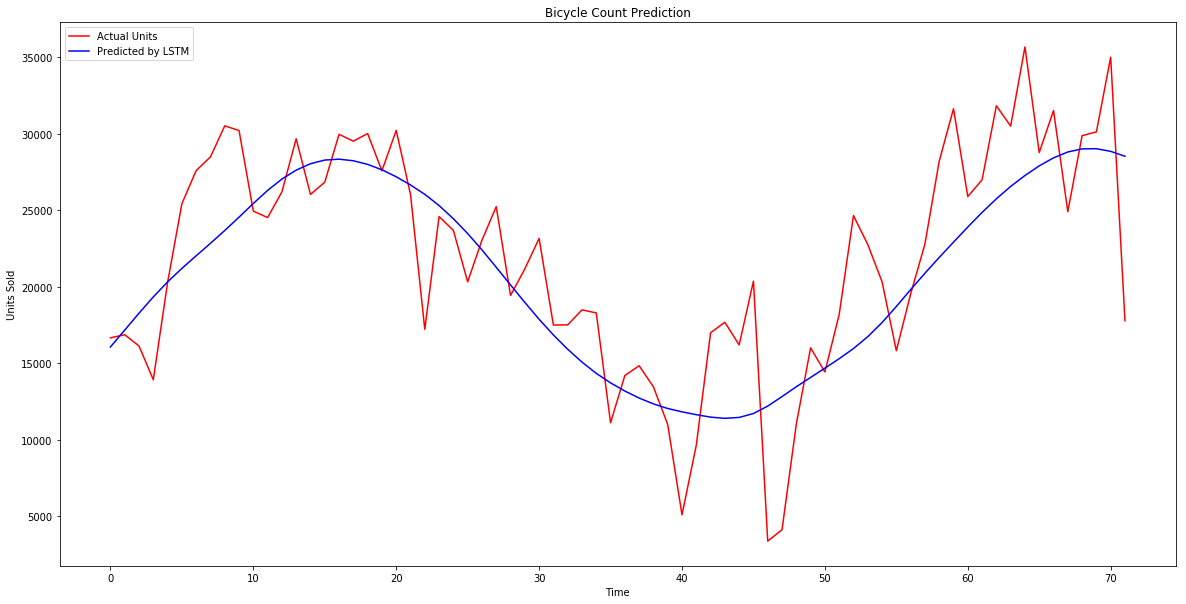

In [36]:
# Visualising results
plt.plot(real, color = 'red', label = 'Actual Units')
plt.plot(pred, color = 'blue', label = 'Predicted by LSTM')
plt.title('Bicycle Count Prediction')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

### Other models

Let's compare LSTM with other traditional time series models.

#### Simple Exponential Smoothing

In [37]:
ses = SimpleExpSmoothing(train['Total']).fit().forecast(len(test))
abs(test['Total'] - ses).sum() /test['Total'].sum() # 31.1%

0.3109595617780631

#### Holt-Winter Exponential Smoothing

In [38]:
hwes = ExponentialSmoothing(train['Total'], seasonal='add', seasonal_periods = 52).fit().forecast(len(test))
abs(test['Total'] - hwes).sum() /test['Total'].sum() # 13.5%

0.13512515159536886

#### Moving Average

In [21]:
history = train['Total'].tolist()
for i in range(len(test)):
    ma = sum(history[-4:]) / 4
    history.append(ma)

ma = history[-len(test):]
abs(test['Total'] - ma).sum() /test['Total'].sum() # 33.9%

0.3390056020854423

#### SARIMA

In [18]:
autoarima = auto_arima(train, m = 52,
                  trace=True, error_action='ignore',
                  stationary = False, disp=-1,stepwise=True,
                  suppress_warnings=True)
# model parameter: (2,0,2) * (1,0,1,52)

sarima = autoarima.predict(len(test))
abs(test['Total'] - sarima).sum() /test['Total'].sum() # 22.1%

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=5349.079, BIC=5378.299, Fit time=14.270 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=5789.647, BIC=5796.952, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=5515.199, BIC=5529.809, Fit time=5.033 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 52); AIC=5359.641, BIC=5385.208, Fit time=3.729 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=5375.794, BIC=5397.709, Fit time=0.178 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 52); AIC=nan, BIC=nan, 

0.22093986914505515

#### SARIMAX

In [23]:
# Get US holiday data from 2012 to 2019
dat = list()
holiday = list()
for date, name in sorted(holidays.US(state='CA', 
                                     years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]).items()):
    dat.append(date)
    holiday.append(name)

holidays = pd.DataFrame(list(zip(dat, holiday)), columns = ['Date', 'Holiday'])
holidays['Date'] = holidays['Date'].astype('datetime64')

# merge holiday table with main table
daily = data.resample('D')['Total'].sum().reset_index()
daily = daily.merge(holidays, how = 'left', on = 'Date').fillna(0)
daily['Count'] = 1
daily_pivot = pd.pivot_table(daily, index = ['Date', 'Total'], 
                             values = 'Count', columns = ['Holiday'], fill_value = 0).reset_index()
daily_pivot.drop(columns = 0, axis = 1, inplace = True)

# aggregate to weekly level
daily_pivot = daily_pivot.set_index('Date')
weekly_exog = daily_pivot.resample('W').sum()

# split into train and test
size = int(len(weekly_exog) * .8)
train2, test2 = weekly_exog[0:size], weekly_exog[size:len(weekly_exog)]

# fit model 
sarimax = auto_arima(train2.iloc[:, :1], m = 52, exogenous = train2.iloc[:, 1:],
                  trace=True, error_action='ignore',
                  stationary = False, disp=-1,stepwise=True,
                  suppress_warnings=True).predict(len(test), exogenous = test2.iloc[:, 1:])

abs(test['Total'] - sarimax).sum() /test['Total'].sum() # 21.3%

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=5906.243, BIC=6001.208, Fit time=38.618 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=6081.596, BIC=6154.646, Fit time=0.075 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=5968.161, BIC=6048.515, Fit time=15.949 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=5973.612, BIC=6053.966, Fit time=6.194 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 52); AIC=5930.090, BIC=6021.402, Fit time=37.330 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 52); AIC=5905.177, BIC=6003.794, Fit time=202.750 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 0, 52); AIC=5905.757, BIC=6000.722, Fit time=140.340 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 52); AIC=5904.205, BIC=5995.517, Fit time=23.002 seconds
Fit ARIMA: order=(1, 0, 2) seaso

0.21254625559453416

Let's visualize the predictions by all models.

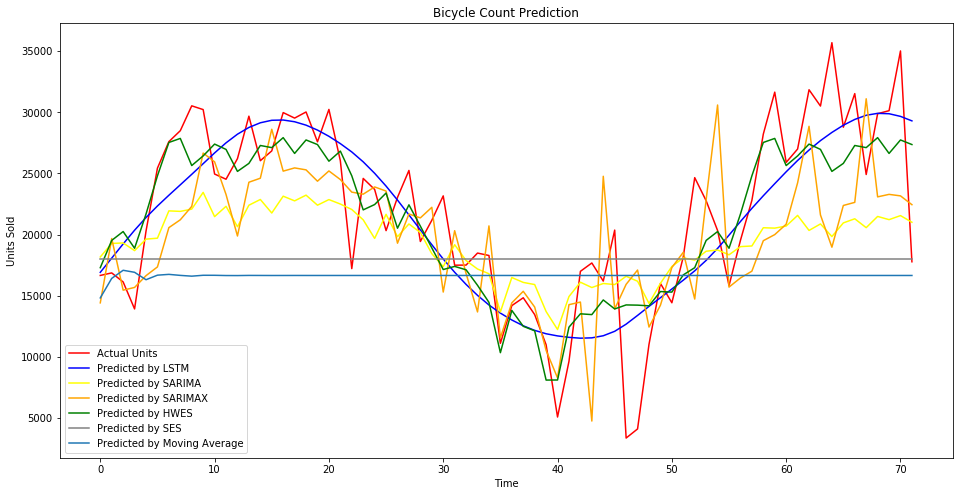

In [28]:
# Visualising the results
plt.plot(real, color = 'red', label = 'Actual Units')
plt.plot(pred, color = 'blue', label = 'Predicted by LSTM')
plt.plot(sarima, color = 'yellow', label = 'Predicted by SARIMA')
plt.plot(sarimax, color = 'orange', label = 'Predicted by SARIMAX')
plt.plot(hwes.values, color = 'green', label = 'Predicted by HWES')
plt.plot(ses.values, color = 'gray', label = 'Predicted by SES')
plt.plot(ma,label = 'Predicted by Moving Average')
plt.title('Bicycle Count Prediction')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

Overall, LSTM outperforms most of the time series models as it captures the trend properly. However, it performs slightly worse than Holt-Winter Exponential Smoothing.